## COMPRA O ALQUILER DE VIVIENDA

Aplicando algoritmo Naive-Bayes para decidir, en función de datos financieros, cuál es la opción más plausible para disponer de una vivienda

### Importamos librerías

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sb
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest

In [25]:
dataframe = pd.read_csv("./datasets/comprar_alquilar.csv")
dataframe.head(10)

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1
5,5692,911,11,325,50875,360863,1,4,5,1
6,6830,1298,345,309,46761,429812,1,1,5,1
7,6470,1035,39,782,57439,606291,0,0,1,0
8,6251,1250,209,571,50503,291010,0,0,3,1
9,6987,1258,252,245,40611,324098,2,1,7,1


## Descripción de los campos:  

*ingresos*: los ingresos de la familia mensual  
*gastos comunes*: pagos de luz, agua, gas, etc mensual  
*pago coche*: si se está pagando cuota por uno o más coches, y los gastos en combustible, etc al mes.  
*gastos_otros*: compra en supermercado y lo necesario para vivir al mes  
*ahorros*: suma de ahorros dispuestos a usar para la compra de la casa.  
*vivienda*: precio de la vivienda que quiere comprar esa familia  
*estado civil*:  
-  0-soltero
-  1-casados
-  2-divorciados  

*hijos*: cantidad de hijos menores y que no trabajan.  
*trabajo*:    
- 0-sin empleo  
- 1-autónomo (freelance)
- 2-empleado
- 3-empresario
- 4-pareja: autónomos
- 5-pareja: empleados
- 6-pareja: autónomo y asalariado
- 7-pareja:empresario y autónomo
- 8-pareja: empresarios los dos o empresario y empleado
*comprar*:   
- 0-No comprar 
- 1-Comprar (esta será nuestra columna de salida, para aprender)

In [26]:
print(dataframe.groupby('comprar').size())

comprar
0    135
1     67
dtype: int64


Tenemos 67 registros que recomiendan comprar y 135 en los que no

In [27]:
dataframe.drop(['comprar'],axis=1).hist
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

## Preparar datos de entrada

Se agrupan diversos gastos y se crea una columna a la que se denomina **financiar** que será la resta del precio de la vivienda con los ahorros de la familia

In [28]:
dataframe['gastos']=(dataframe['gastos_comunes']+dataframe['gastos_otros']+dataframe['pago_coche'])
dataframe['financiar']=dataframe['vivienda']-dataframe['ahorros']
dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'], axis=1).head(10)

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
0,6000,50000,400000,0,2,2,1,1600,350000
1,6745,43240,636897,1,3,6,0,1496,593657
2,6455,57463,321779,2,1,8,1,1926,264316
3,7098,54506,660933,0,0,3,0,1547,606427
4,6167,41512,348932,0,0,3,1,1606,307420
5,5692,50875,360863,1,4,5,1,1247,309988
6,6830,46761,429812,1,1,5,1,1952,383051
7,6470,57439,606291,0,0,1,0,1856,548852
8,6251,50503,291010,0,0,3,1,2030,240507
9,6987,40611,324098,2,1,7,1,1755,283487


Realizamos resumen estadistico mediante la función **describe()** de la librería Pandas

In [29]:
reduced = dataframe.drop(['gastos_comunes','gastos_otros','pago_coche'],axis=1)
reduced.describe()

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,4958.995050,38749.668317,373349.638614,1.024752,1.232673,4.490099,0.331683,1698.752475,334599.970297
std,1682.862556,17365.231870,136371.525622,0.837184,1.367833,2.535794,0.471988,324.838005,126607.099497
min,2008.000000,10319.000000,176553.000000,0.000000,0.000000,0.000000,0.000000,1007.000000,154716.000000
25%,3513.750000,24964.250000,274810.000000,0.000000,0.000000,2.000000,0.000000,1430.500000,240410.250000
50%,4947.500000,38523.000000,340783.500000,1.000000,1.000000,5.000000,0.000000,1669.500000,301177.000000
75%,6374.500000,52150.750000,444482.000000,2.000000,2.000000,7.000000,1.000000,1928.000000,393413.000000
max,7984.000000,69934.000000,669540.000000,2.000000,4.000000,8.000000,1.000000,2543.000000,618621.000000


## Selección de características

En lugar de emplear todas las columnas, usaremos las 5 mejores características utilizando la clase de Sklearn que se denomina SelectKBest.

In [30]:
X=dataframe.drop(['comprar'], axis=1)
y=dataframe['comprar']

best=SelectKBest(k=5)
X_new = best.fit_transform(X, y)
X_new.shape
selected = best.get_support(indices=True)
print(X.columns[selected])

Index(['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar'], dtype='object')


Por tanto, usamos las columnas (características) que nos devuelve dicha clase como aquellas características "que más aportan" en el proceso de clasificación.  
Analizamos a continuación, el grado de correlación de las mismas.

<Axes: title={'center': 'Pearson Correlation of Features'}>

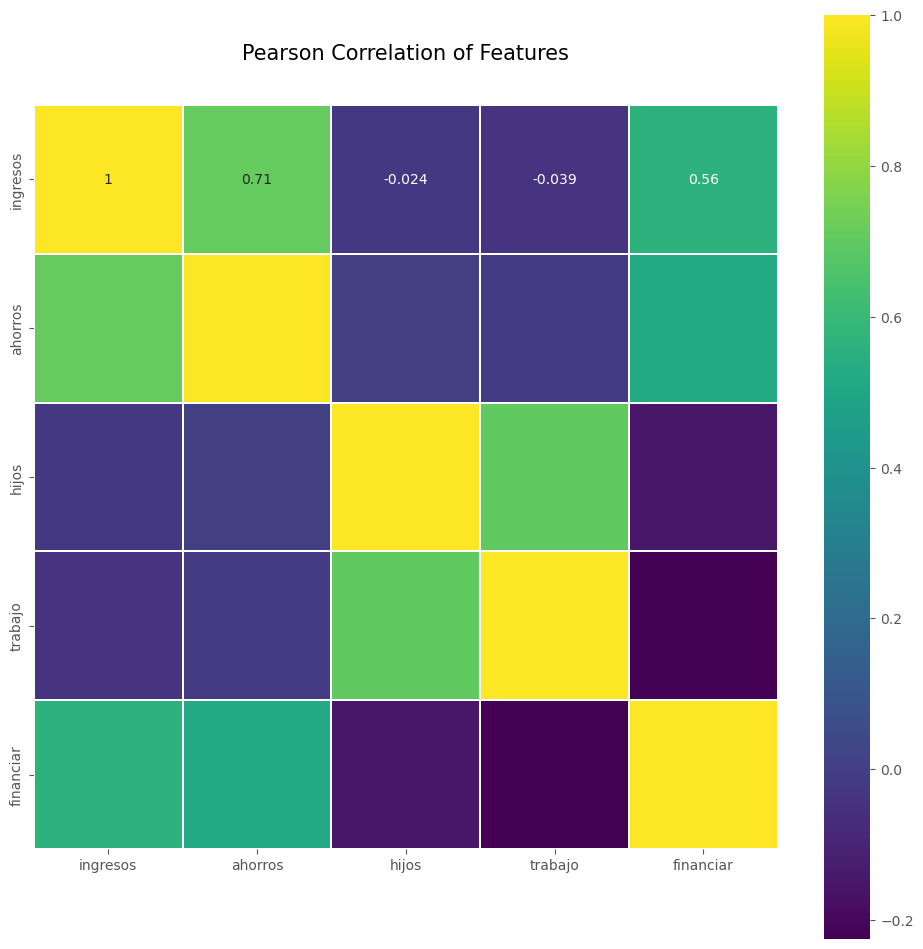

In [31]:
used_features =X.columns[selected]

colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(dataframe[used_features].astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Se puede comprobar que, en general, están poco correlacionadas, sin embargo también tenemos 2 valores de 0,7.   
Cabe esperar que el algoritmo sea lo suficientemente “naive” para dar buenos resultados

## Preparamos los conjuntos TRAIN y TEST

In [32]:

X_train, X_test = train_test_split(dataframe, test_size=0.2, random_state=6) 
y_train =X_train["comprar"]
y_test = X_test["comprar"]

## Construimos y entrenamos el modelo

In [33]:
# Instantiate the classifier
gnb = GaussianNB()
# Train classifier
gnb.fit(
    X_train[used_features].values,
    y_train
)
y_pred = gnb.predict(X_test[used_features])

print("Accuracy del modelo GNB: ", accuracy_score(y_test,y_pred))
print('Precisión en el set de Entrenamiento: {:.2f}'
     .format(gnb.score(X_train[used_features], y_train)))
print('Precisión en el set de Test: {:.2f}'
     .format(gnb.score(X_test[used_features], y_test)))

Accuracy del modelo GNB:  0.9024390243902439
Precisión en el set de Entrenamiento: 0.87
Precisión en el set de Test: 0.90


e:\Users\Jordi\anaconda3\envs\ceiadb\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
e:\Users\Jordi\anaconda3\envs\ceiadb\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
e:\Users\Jordi\anaconda3\envs\ceiadb\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


## Realizando predicciones para probar el modelo

Ahora, hagamos 2 predicciones para probar nuestra máquina:  

- En un caso será una familia sin hijos con 2.000€ de ingresos que quiere comprar una casa de 200.000€ y tiene sólo 5.000€ ahorrados.  
- El otro será una familia con 2 hijos con ingresos por 6.000€ al mes, 34.000 en ahorros y consultan si comprar una casa de 320.000€.

In [34]:
#                 ['ingresos', 'ahorros', 'hijos', 'trabajo', 'financiar']
print(gnb.predict([[2000,        5000,     0,       5,         200000],
                   [6000,        34000,    2,       5,         320000] ]))
#Resultado esperado 0-Alquilar, 1-Comprar casa

[0 1]


Los resultados son los esperados, en el primer caso, recomienda Alquilar (0) y en el segundo comprar la casa (1).